# ECG Beat Segmentation, Normalization, and Labeling Pipeline

This notebook presents a comprehensive pipeline for the segmentation, normalization, and labeling of ECG signals using the PTB-XL dataset. The workflow includes data preprocessing, beat-wise segmentation, per-beat normalization, assignment of multilabel targets, dataset partitioning (train, validation, and test), exploratory visualization, and figure exportation for use in deep learning frameworks (e.g., CNN/LSTM). The procedures are documented in academic English, with an emphasis on reproducibility and clarity.

---


Import Lib

In [1]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

from scipy.signal import find_peaks, butter, filtfilt
from sklearn.model_selection import train_test_split


sns.set_style('darkgrid')
folder = 'gambar_data'  # output folder (modify the path as needed)
os.makedirs(folder, exist_ok=True)

Superclasses enumerated by dataset description are as follows:
```
Records | Superclass | Description
9528 | NORM | Normal ECG (NORM)
5486 | MI | Myocardial Infarction (MI)
5250 | STTC | ST/T Change (STTC)
4907 | CD | Conduction Disturbance (CD)
2655 | HYP | Hypertrophy (HYP)
```

Read Data

In [2]:
PATH_TO_DATA = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

ECG_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'ptbxl_database.csv'), index_col='ecg_id')
ECG_df.scp_codes = ECG_df.scp_codes.apply(lambda x: ast.literal_eval(x))
ECG_df.patient_id = ECG_df.patient_id.astype(int)
ECG_df.nurse = ECG_df.nurse.astype('Int64')
ECG_df.site = ECG_df.site.astype('Int64')
ECG_df.validated_by = ECG_df.validated_by.astype('Int64')

SCP_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'scp_statements.csv'), index_col=0)
SCP_df = SCP_df[SCP_df.diagnostic == 1]

ECG_df

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709,56.0,1,NaN,63.0,2,0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243,19.0,0,NaN,70.0,2,0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372,37.0,1,NaN,69.0,2,0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014,24.0,0,NaN,82.0,2,0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448,19.0,1,NaN,70.0,2,0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180,67.0,1,NaN,NaN,1,2,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703,93.0,0,NaN,NaN,1,2,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311,59.0,1,NaN,NaN,1,2,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [3]:
def diagnostic_class(scp):
    res = set()
    for k in scp.keys():
        if k in SCP_df.index:
            res.add(SCP_df.loc[k].diagnostic_class)
    return list(res)
                    
ECG_df['scp_classes'] = ECG_df.scp_codes.apply(diagnostic_class)

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate = 100

ECG_data = load_raw_data(ECG_df, sampling_rate, PATH_TO_DATA)

ECG_data.shape

(21837, 1000, 12)

In [5]:
# ===========================
# Bandpass filter function
# ===========================
def bandpass_filter(signal, fs, low=0.5, high=40):
    b, a = butter(2, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, signal)

In [6]:
ECG_df[[col for col in ECG_df.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                      18885
age                                94
sex                                 2
height                             77
weight                            127
nurse                              12
site                               51
device                             11
recording_date                  21813
report                           9883
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    321
static_noise                      124
burst_noise                       103
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21837
filename_hr                     21837
dtype: int64

In [7]:
X = pd.DataFrame(index=ECG_df.index)

X['age'] = ECG_df.age
X.age.fillna(0, inplace=True)

X['sex'] = ECG_df.sex.astype(float)
X.sex.fillna(0, inplace=True)

X['height'] = ECG_df.height
X.loc[X.height < 50, 'height'] = np.nan
X.height.fillna(0, inplace=True)

X['weight'] = ECG_df.weight
X.weight.fillna(0, inplace=True)

X['infarction_stadium1'] = ECG_df.infarction_stadium1.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ECG_df.infarction_stadium2.replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

X['pacemaker'] = (ECG_df.pacemaker == 'ja, pacemaker').astype(float)

X

C:\Users\User\AppData\Local\Temp\ipykernel_7216\3316299910.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X.age.fillna(0, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_7216\3316299910.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[co

,age,sex,height,weight,infarction_stadium1,infarction_stadium2,pacemaker
ecg_id,,,,,,,
1,56.0,1.0,0.0,63.0,0.0,0.0,0.0
2,19.0,0.0,0.0,70.0,0.0,0.0,0.0
3,37.0,1.0,0.0,69.0,0.0,0.0,0.0
4,24.0,0.0,0.0,82.0,0.0,0.0,0.0
5,19.0,1.0,0.0,70.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,67.0,1.0,0.0,0.0,0.0,0.0,0.0
21834,93.0,0.0,0.0,0.0,4.0,0.0,0.0
21835,59.0,1.0,0.0,0.0,0.0,0.0,0.0


Z targets (target)

In [8]:
Z = pd.DataFrame(0, index=ECG_df.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in ECG_df.loc[i].scp_classes:
        Z.loc[i, k] = 1

Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


Splitting to train, validate and test datasets

As the authors of PTB-XL ECG dataset suggest, I will split all input and output dataset to training, validation and test subsets according *strat_fold* column.

In [9]:
X_data = X[ECG_df.strat_fold <= 10]
Y_data = ECG_data[X_data.index - 1]   # index record ke-0
Z_data = Z[ECG_df.strat_fold <= 10]

print("X:", Y_data.shape)
print("y:", Z_data.shape)

X: (21837, 1000, 12)
y: (21837, 5)


In [10]:
def segment_beats_multi_lead(record, fs=100, pre_s=0.15, post_s=0.4):
    """
    record: shape (n_sample, 12)
    return: array (n_beat, window, 12)
    """
    from scipy.signal import find_peaks

    pre = int(pre_s * fs)
    post = int(post_s * fs)
    expected_len = pre + post

    # Pakai Lead II (kolom ke-1) untuk deteksi peak
    signal = record[:, 1]
    # Optional: filter sinyal, misal bandpass_filter(signal, fs)
    height_thresh = np.percentile(signal, 99) * 0.6
    distance = int(0.5 * fs)
    peaks, _ = find_peaks(signal, height=height_thresh, distance=distance)

    beats = []
    for r in peaks:
        start = max(r - pre, 0)
        end = min(r + post, record.shape[0])
        if end - start == expected_len:
            beat = record[start:end, :]   # Semua 12 lead!
            beats.append(beat)
    if beats:
        return np.stack(beats)
    else:
        return np.empty((0, expected_len, 12))  # Jika tidak ada beat valid

# Contoh segmentasi pada 1 record:
record = Y_data[0]  # shape (1000, 12)
beats = segment_beats_multi_lead(record, fs=100)
print("Beats shape:", beats.shape)  # (n_beat, window, 12)

all_record_beats = []
for rec in Y_data:
    beats = segment_beats_multi_lead(rec, fs=100)
    all_record_beats.append(beats)  # list of (n_beat_i, window, 12)

Beats shape: (10, 55, 12)


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tentukan max_n_beat (misal, 10 beat per record)
max_n_beat = 10
window = 55
n_lead = 12

# Fungsi padding beat per record
def pad_beats(beats, max_n_beat=10, window=55, n_lead=12):
    # beats: (n_beat, window, n_lead)
    n_beat = beats.shape[0]
    pad = np.zeros((max_n_beat, window, n_lead))
    pad[:min(n_beat, max_n_beat), :, :] = beats[:max_n_beat, :, :]
    return pad

all_record_beats_padded = np.stack([pad_beats(b, max_n_beat, window, n_lead) for b in all_record_beats])
print(all_record_beats_padded.shape)  # (21837, 10, 55, 12)

(21837, 10, 55, 12)


In [12]:
import numpy as np

def stratified_split_per_class(X, y, train_frac=0.7, val_frac=0.2, test_frac=0.1, seed=42):
    """
    X: array (n_record, ...)
    y: one-hot label (n_record, n_class)
    """
    np.random.seed(seed)
    n_class = y.shape[1]
    train_idx, val_idx, test_idx = [], [], []
    y_label = y.argmax(axis=1)

    for cls in range(n_class):
        idx = np.where(y_label == cls)[0]
        np.random.shuffle(idx)
        n = len(idx)
        n_train = int(n * train_frac)
        n_val = int(n * val_frac)
        n_test = n - n_train - n_val
        train_idx.extend(idx[:n_train])
        val_idx.extend(idx[n_train:n_train+n_val])
        test_idx.extend(idx[n_train+n_val:])

    # Shuffle index agar tidak urut per kelas
    train_idx = np.array(train_idx)
    val_idx = np.array(val_idx)
    test_idx = np.array(test_idx)
    np.random.shuffle(train_idx)
    np.random.shuffle(val_idx)
    np.random.shuffle(test_idx)

    X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
    y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

# --------- PEMAKAIAN -------------
X_train, X_val, X_test, y_train, y_val, y_test = stratified_split_per_class(
    all_record_beats_padded, Z_data.values 
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (15284, 10, 55, 12) (15284, 5)
Val:   (4366, 10, 55, 12) (4366, 5)
Test:  (2187, 10, 55, 12) (2187, 5)


pembagian kelas

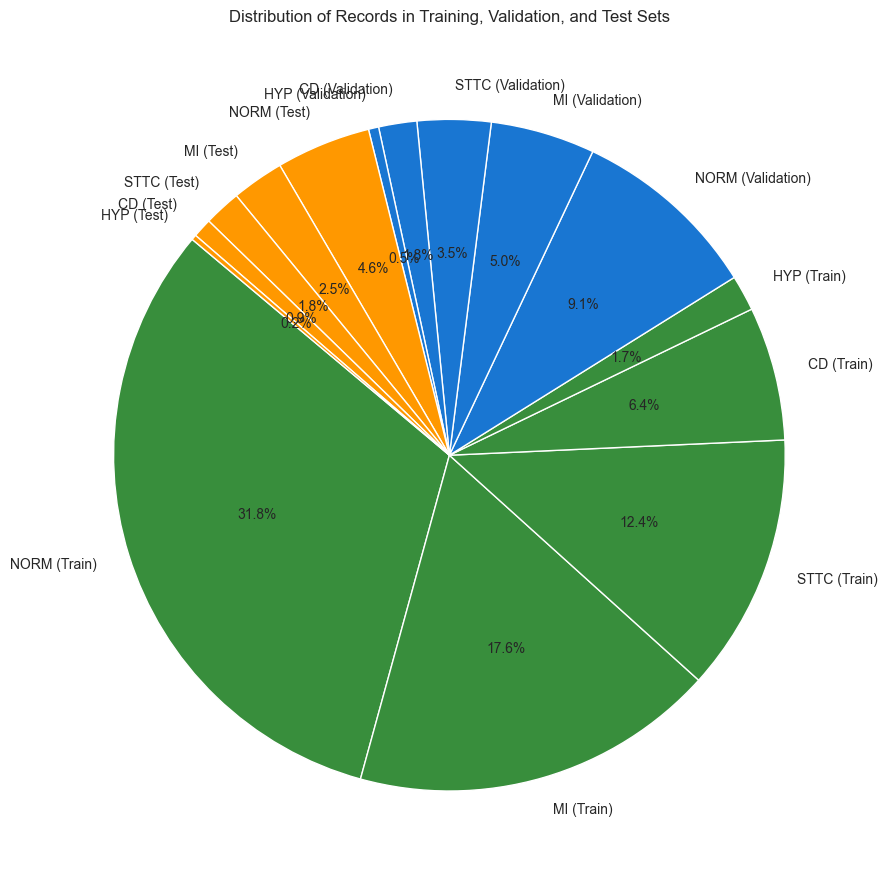

Class  Train  Valid  Test       %
 NORM   6954   1987   994  45.50%
   MI   3839   1097   549  25.12%
 STTC   2710    774   388  17.73%
   CD   1406    401   202   9.20%
  HYP    375    107    54   2.45%
TOTAL  15284   4366  2187 100.00%


In [13]:
import numpy as np
import matplotlib.pyplot as plt

label_names = ['NORM', 'MI', 'STTC', 'CD', 'HYP']



# convert one-hot to int label
train_labels = y_train.argmax(axis=1)
val_labels = y_val.argmax(axis=1)
test_labels = y_test.argmax(axis=1)

# Urutkan: semua kelas train, semua kelas val, semua kelas test
pie_labels = []
pie_values = []
colors = []

palette_train = '#388e3c'
palette_val = '#1976d2'
palette_test = '#ff9800'

# -- Train dulu semua kelas --
for i, name in enumerate(label_names):
    pie_labels.append(f"{name} (Train)")
    pie_values.append(np.sum(train_labels == i))
    colors.append(palette_train)
# -- Val --
for i, name in enumerate(label_names):
    pie_labels.append(f"{name} (Validation)")
    pie_values.append(np.sum(val_labels == i))
    colors.append(palette_val)
# -- Test --
for i, name in enumerate(label_names):
    pie_labels.append(f"{name} (Test)")
    pie_values.append(np.sum(test_labels == i))
    colors.append(palette_test)

plt.figure(figsize=(9, 9))
plt.pie(
    pie_values,
    labels=pie_labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10},
)
plt.title('Distribution of Records in Training, Validation, and Test Sets')
plt.axis('equal')
plt.tight_layout()
plt.show()

rows = []
total_train = len(train_labels)
total_val = len(val_labels)
total_test = len(test_labels)
total_all = total_train + total_val + total_test

for i, name in enumerate(label_names):
    n_train = np.sum(train_labels == i)
    n_val = np.sum(val_labels == i)
    n_test = np.sum(test_labels == i)
    n_total = n_train + n_val + n_test
    rows.append([
        name, 
        n_train, 
        n_val, 
        n_test, 
        f"{100*n_total/total_all:.2f}%"
    ])
rows.append(['TOTAL', total_train, total_val, total_test, "100.00%"])

df = pd.DataFrame(rows, columns=['Class', 'Train', 'Valid', 'Test', '%'])
print(df.to_string(index=False))


save data

In [14]:
import os
import numpy as np

output_dir = "data_ready_segmentation_beats_v2"
os.makedirs(output_dir, exist_ok=True)

# Simpan X dan y, misal data sudah split seperti:
# X_train, X_val, X_test, y_train, y_val, y_test

# Save per array (format .npy)
np.save(os.path.join(output_dir, 'X_train.npy'), X_train)
np.save(os.path.join(output_dir, 'y_train.npy'), y_train)
np.save(os.path.join(output_dir, 'X_val.npy'), X_val)
np.save(os.path.join(output_dir, 'y_val.npy'), y_val)
np.save(os.path.join(output_dir, 'X_test.npy'), X_test)
np.save(os.path.join(output_dir, 'y_test.npy'), y_test)

np.savez_compressed(os.path.join(output_dir, "X_train_beats.npz"), X_train_beats=X_train)
np.savez_compressed(os.path.join(output_dir, "X_valid_beats.npz"), X_valid_beats=X_val)
np.savez_compressed(os.path.join(output_dir, "X_test_beats.npz"),  X_test_beats=X_test)

np.savez_compressed(os.path.join(output_dir, "y_train_beats.npz"), Z_train_beats=y_train)
np.savez_compressed(os.path.join(output_dir, "y_valid_beats.npz"), Z_valid_beats=y_val)
np.savez_compressed(os.path.join(output_dir, "y_test_beats.npz"),  Z_test_beats=y_test)


print("Data saved to:", output_dir)


Data saved to: data_ready_segmentation_beats_v2


END of data view and preprocessing